In [1]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from scipy.stats import ttest_ind

### Load patient data from spreadsheet

In [2]:
patients_df = (
    pd.read_excel(
        "DB AF Completo 1.ods",
    )
    .loc[:, ["ID", "Phenotype", "Low Voltage / Scar area", "Rhythm during Mapping"]]
    .rename(
        columns={
            "ID": "PatientID",
            "Low Voltage / Scar area": "Substrate",
            "Rhythm during Mapping": "Rhythm",
        }
    )
    .dropna(axis=0, how="any")
    .astype({"PatientID": int})
)

phenotype_mapping = {
    "Long standing persistent": "Persistent",
    "Persistente": "Persistent",
    "Parossistica": "Paroxysmal",
    "Parossistico": "Paroxysmal",
    "Persistent": "Persistent",
    "Paroxysmal": "Paroxysmal",
}

substrate_mapping = {
    "Normal": "Normal",
    "Normale": "Normal",
    "Abnormal": "Abnormal",
    "Patologia": "Abnormal",
    "Patologia ": "Abnormal",
    "Patologia altri distretti": "Abnormal",
    "Patologia parete posteriore": "Abnormal",
    "Patologia parete posteriore e anteriore": "Abnormal",
    "Patologia posteriore + altri": "Abnormal",
    "Patologia posteriore e+ altri": "Abnormal",
}

rhythm_mapping = {
    "AF": "AF",
    "FA": "AF",
    "SR": "SR",
    "RS": "SR",
}

patients_df["Phenotype"] = patients_df["Phenotype"].map(phenotype_mapping)
patients_df["Substrate"] = patients_df["Substrate"].map(substrate_mapping)
patients_df["Rhythm"] = patients_df["Rhythm"].map(rhythm_mapping)

patients_df

,PatientID,Phenotype,Substrate,Rhythm
3,9,Persistent,Abnormal,AF
4,10,Paroxysmal,Normal,SR
5,11,Persistent,Normal,AF
6,12,Persistent,Abnormal,SR
7,13,Persistent,Abnormal,AF
...,...,...,...,...
171,154,Paroxysmal,Normal,SR
177,160,Paroxysmal,Normal,SR
178,161,Paroxysmal,Normal,SR
179,162,Paroxysmal,Normal,SR


### Show plots of a specific experiment

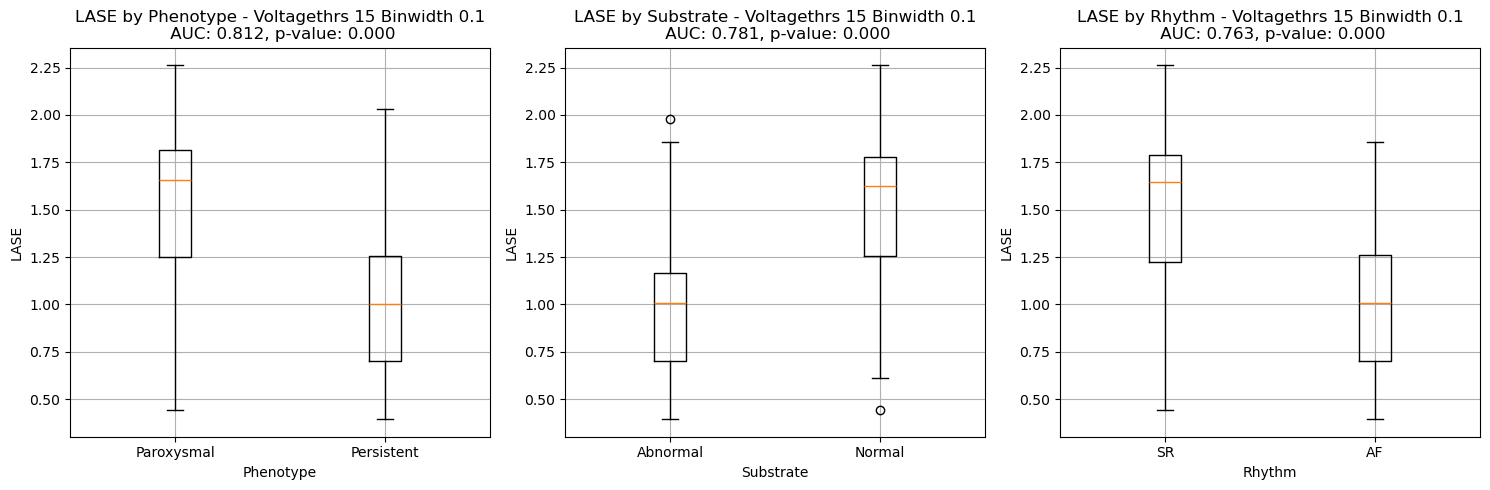

In [3]:
results_dir = "results"
experiment_name = "voltageThrs_15_binWidth_0.1"
results_path = os.path.join(results_dir, experiment_name, "results.json")

with open(results_path, "r") as f:
    results_dict = json.load(f)
parameters = results_dict["parameters"]
results = results_dict["results"]

results_df = pd.DataFrame(results)
results_df = results_df.astype(
    {
        "PatientID": int,
        "LASE": float,
    }
)

results_df = results_df.merge(
    patients_df,
    on="PatientID",
    how="left",
)

# Extracting LASE values
abnormal_lase = results_df[results_df["Substrate"] == "Abnormal"]["LASE"]
normal_lase = results_df[results_df["Substrate"] == "Normal"]["LASE"]
paroxysmal_lase = results_df[results_df["Phenotype"] == "Paroxysmal"]["LASE"]
persistent_lase = results_df[results_df["Phenotype"] == "Persistent"]["LASE"]
SR_lase = results_df[results_df["Rhythm"] == "SR"]["LASE"]
AF_lase = results_df[results_df["Rhythm"] == "AF"]["LASE"]

y_pred = results_df.loc[:, "LASE"].values
# Plotting the results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.boxplot(
    [paroxysmal_lase, persistent_lase],
    tick_labels=["Paroxysmal", "Persistent"],
)
plt.title(f"LASE by Phenotype - {experiment_name.replace('_', ' ').title()}\n AUC: {roc_auc_score(results_df['Phenotype'].apply(lambda x: 1 if x == 'Paroxysmal' else 0), y_pred):.3f}, p-value: {ttest_ind(paroxysmal_lase, persistent_lase, equal_var=False, alternative='greater').pvalue:.3f}")  # type: ignore
plt.ylabel("LASE")
plt.xlabel("Phenotype")
plt.grid()
plt.subplot(1, 3, 2)
plt.boxplot(
    [abnormal_lase, normal_lase],
    tick_labels=["Abnormal", "Normal"],
)
plt.title(f"LASE by Substrate - {experiment_name.replace('_', ' ').title()}\n AUC: {roc_auc_score(results_df['Substrate'].apply(lambda x: 1 if x == 'Normal' else 0), y_pred):.3f}, p-value: {ttest_ind(abnormal_lase, normal_lase, equal_var=False, alternative='less').pvalue:.3f}")  # type: ignore
plt.ylabel("LASE")
plt.xlabel("Substrate")
plt.grid()
plt.subplot(1, 3, 3)
plt.boxplot(
    [SR_lase, AF_lase],
    tick_labels=["SR", "AF"],
)
plt.title(f"LASE by Rhythm - {experiment_name.replace('_', ' ').title()}\n AUC: {roc_auc_score(results_df['Rhythm'].apply(lambda x: 1 if x == 'SR' else 0), y_pred):.3f}, p-value: {ttest_ind(SR_lase, AF_lase, equal_var=False, alternative='greater').pvalue:.3f}")  # type: ignore
plt.ylabel("LASE")
plt.xlabel("Rhythm")
plt.grid()
plt.tight_layout()
plt.show()

### Compute results metrics for all experiments

In [4]:
from sklearn.metrics import roc_auc_score
from scipy.stats import ttest_ind


def compute_metrics(results_df):
    # Prepare groups
    abnormal_lase = results_df[results_df["Substrate"] == "Abnormal"]["LASE"]
    normal_lase = results_df[results_df["Substrate"] == "Normal"]["LASE"]
    paroxysmal_lase = results_df[results_df["Phenotype"] == "Paroxysmal"]["LASE"]
    persistent_lase = results_df[results_df["Phenotype"] == "Persistent"]["LASE"]
    SR_lase = results_df[results_df["Rhythm"] == "SR"]["LASE"]
    AF_lase = results_df[results_df["Rhythm"] == "AF"]["LASE"]
    y_pred = results_df["LASE"].values

    # Compute metrics
    metrics = {}
    # Phenotype
    y_true_phenotype = results_df["Phenotype"].apply(
        lambda x: 1 if x == "Paroxysmal" else 0
    )
    auc_phenotype = roc_auc_score(y_true_phenotype, y_pred)
    pval_phenotype = ttest_ind(
        paroxysmal_lase, persistent_lase, equal_var=False, alternative="greater"
    ).pvalue  # type: ignore

    # Substrate
    y_true_substrate = results_df["Substrate"].apply(
        lambda x: 1 if x == "Normal" else 0
    )
    auc_substrate = roc_auc_score(y_true_substrate, y_pred)
    pval_substrate = ttest_ind(
        abnormal_lase, normal_lase, equal_var=False, alternative="less"
    ).pvalue  # type: ignore

    # Rhythm
    y_true_rhythm = results_df["Rhythm"].apply(lambda x: 1 if x == "SR" else 0)
    auc_rhythm = roc_auc_score(y_true_rhythm, y_pred)
    pval_rhythm = ttest_ind(
        SR_lase, AF_lase, equal_var=False, alternative="greater"
    ).pvalue  # type: ignore

    metrics["Phenotype AUC"] = round(auc_phenotype, 3)
    metrics["Phenotype p-value"] = round(pval_phenotype, 3)
    metrics["Substrate AUC"] = round(auc_substrate, 3)
    metrics["Substrate p-value"] = round(pval_substrate, 3)
    metrics["Rhythm AUC"] = round(auc_rhythm, 3)
    metrics["Rhythm p-value"] = round(pval_rhythm, 3)
    return metrics


experiment_metrics = []
for exp_folder in os.listdir(results_dir):
    results_file = os.path.join(results_dir, exp_folder, "results.json")
    if not os.path.isfile(results_file):
        continue
    with open(results_file, "r") as f:
        results_dict = json.load(f)
    parameters = results_dict.get("parameters", {})
    results = results_dict.get("results", [])
    results_df = pd.DataFrame(results)
    # Convert types and merge with patient info
    results_df = results_df.astype({"PatientID": int, "LASE": float})
    results_df = results_df.merge(patients_df, on="PatientID", how="left")
    metrics = compute_metrics(results_df)
    row = {**parameters, **metrics, "experiment": exp_folder}
    experiment_metrics.append(row)

metrics_df = (
    pd.DataFrame(experiment_metrics)
    .sort_values(by="bin_width", ascending=True)
    .reset_index(drop=True)
)
metrics_df.to_csv(os.path.join(results_dir, "experiment_results.csv"), index=False)

metrics_df

,voltage_thrs,bin_width,Phenotype AUC,Phenotype p-value,Substrate AUC,Substrate p-value,Rhythm AUC,Rhythm p-value,experiment
0,15,0.01,0.639,0.139,0.651,0.099,0.612,0.172,voltageThrs_15_binWidth_0.01
1,15,0.05,0.776,0.000,0.756,0.000,0.731,0.000,voltageThrs_15_binWidth_0.05
2,15,0.1,0.812,0.000,0.781,0.000,0.763,0.000,voltageThrs_15_binWidth_0.1
3,15,0.2,0.833,0.000,0.803,0.000,0.782,0.000,voltageThrs_15_binWidth_0.2
4,15,0.3,0.846,0.000,0.811,0.000,0.794,0.000,voltageThrs_15_binWidth_0.3
5,15,variable,0.853,0.000,0.821,0.000,0.799,0.000,voltageThrs_15_binWidth_variable
